# Steered MD in BioSimSpace

The purpose of the steered MD simulation is to access conformational space that would take a very long time (or be inaccessible altogether) at equilibrium. To generate the data for the Markov State Model, we need to see how the system behaves given some starting conformation. To do this, we will be running seeded MD simulations, where a snapshot from the sMD trajectory is used as a starting point for an equilibrium MD simulation.

### Maintainers
* Adele Hardie -- adele.hardie@ed.ac.uk (AdeleHardie)

### Prerequisites
* pandas
* numpy
* matplotlib
* BioSimSpace
* AMBER or GROMACS compiled with PLUMED

### Table of Contents
1. [Plot steering output](#1-Plot-steering-output)
2. [Extract snapshots](#2-Extract-snapshots)

**<span style="color:black">Jupyter Cheat Sheet</span>**
- To run the currently highlighted cell and move focus to the next cell, hold <kbd>&#x21E7; Shift</kbd> and press <kbd>&#x23ce; Enter</kbd>;
- To run the currently highlighted cell and keep focus in the same cell, hold <kbd>&#x21E7; Ctrl</kbd> and press <kbd>&#x23ce; Enter</kbd>;
- To get help for a specific function, place the cursor within the function's brackets, hold <kbd>&#x21E7; Shift</kbd>, and press <kbd>&#x21E5; Tab</kbd>;

### Link to documentation:
You can find the full documentation at [biosimspace.org](https://biosimspace.org).

## 1 Plot steering output

Start by importing required libraries:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import BioSimSpace as BSS
import os

PLUMED outputs a file with the CV value that was used for steering, so we can see the progression during the simulation. The file is automatically named `COLVAR` by BioSimSpace. Here it is loaded as a pandas dataframe.

In [2]:
steering_output_file = "data/COLVAR"
df = pd.read_csv(steering_output_file, sep=" ")
cols = list(df.columns[2:])
df = pd.read_csv(steering_output_file, sep=" ", comment="#", names=cols)

In [3]:
df.head()

,time,r1,t1,d1,@5.bias,@5.force2,@5.r1_cntr,@5.r1_work,@5.r1_kappa,@5.t1_cntr,@5.t1_work,@5.t1_kappa,@5.d1_cntr,@5.d1_work,@5.d1_kappa,@5.work
NaN,0.0,0.158278,1.147716,0.766887,0.000000,0.000000,0.64,0.000000,0.0,1.1,0.000000,0.0,0.56,0.000000,0.0,0.000000
NaN,0.0,0.158278,1.147716,0.766887,0.000000,0.000000,0.64,0.000000,0.0,1.1,0.000000,0.0,0.56,0.000000,0.0,0.000000
NaN,5.0,0.152655,1.079508,0.658121,54.152200,47383.175107,0.64,51.434321,437.5,1.1,1.941488,437.5,0.56,4.832487,437.5,58.208296
NaN,10.0,0.149606,1.150612,0.592055,106.782913,186870.097194,0.64,104.090581,875.0,1.1,2.553425,875.0,0.56,5.550482,875.0,112.194487
NaN,15.0,0.160264,1.149526,0.600328,153.710904,403491.123108,0.64,155.739408,1312.5,1.1,2.993298,1312.5,0.56,6.072465,1312.5,164.805171


The `COLVAR` file contains all of the CV values (`r1,t1,d1`), as well as more information on the force applied and work done.

PLUMED outputs time in picoseconds and RMSD in nanometers. For easier plotting, we change time to nanoseconds and distances to Angstrom.

In [4]:
df["time"] = df["time"] / 1000
df["r1"] = df["r1"] * 10
df["d1"] = df["d1"] * 10
df.set_index("time", inplace=True)

Now the CV changes can be plotted:

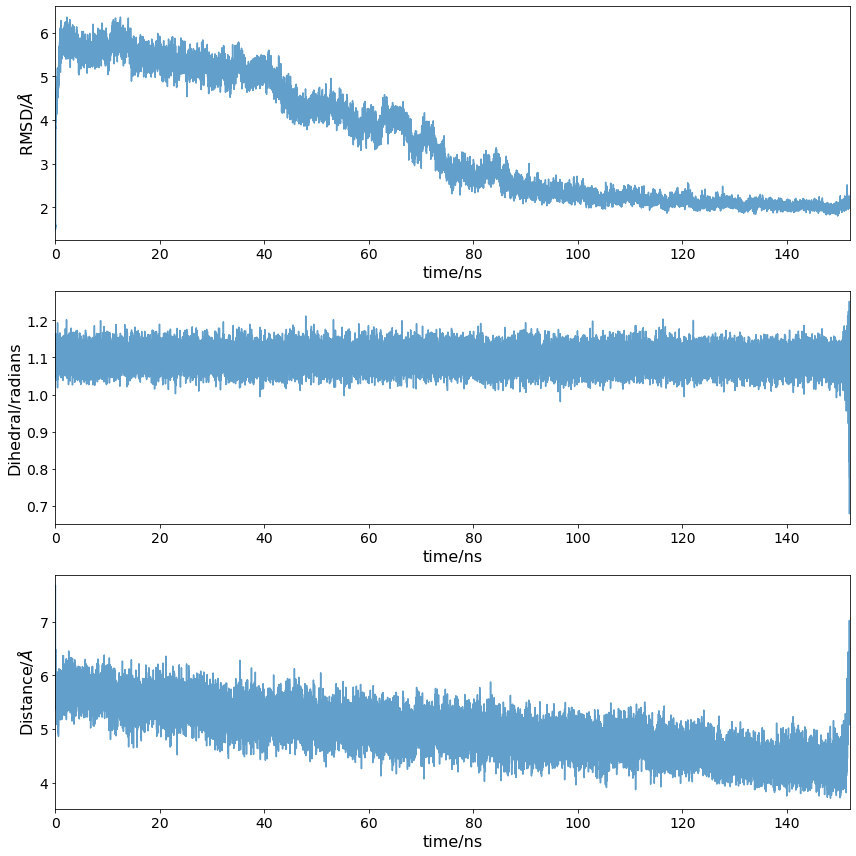

In [5]:
fig, ax = plt.subplots(3, figsize=(12, 12))

columns = ["r1", "t1", "d1"]
ylabels = ["RMSD/$\AA$", "Dihedral/radians", "Distance/$\AA$"]

for i in range(len(columns)):
    ax[i].plot(df.index, df[columns[i]], alpha=0.7)
    ax[i].set_ylabel(ylabels[i])
    ax[i].set_xlabel("time/ns")
    ax[i].set_xlim(0, 152)

fig.tight_layout()

Here the loop RMSD went down to below 2 A (around 1.8 A). This indicates that the loop conformation was very similar to the crystal structure of PTP1B with the loop closed (which was used as the target) and so we can proceed with extracting snapshots to use as seeds. Additionally, the Tyr152 $\chi$1 angle was kept in the "down" rotamer consistently (around 1.1 radians) and the Phe196(C$\gamma$)-Phe280(C$\gamma$) distance was decreased to 4 A, which corresponds to the two residues $\pi$-stacking.

However, sMD might not work on the first try - the steering duration and force constant used is highly dependent on each individual system. Below is an example of a failed WPD loop RMSD steering attempt:

<img src="figures/COLVAR_failed.png">

Here steering was carried out for 80 ns only, and the force constant used was 2500 kJ mol$^{-1}$. The RMSD was decreasing as expected, but didn't go below 2 A. This was deemed insufficient and a longer steering protocol with a larger force constant was decided upon in the end. Ultimately this will depend on the system you are working with and what the goal of the steering is.

## 2 Extract snapshots

In this case we will be extracting 100 evenly spaced snapshots to be used as starting points for the seeded MD simulations.

In [6]:
snapshot_dir = "data"
if not os.path.exists(snapshot_dir):
    os.mkdir(snapshot_dir)

Get frame indices for snapshots. Note that the end point selected is not the end of the simulation, but the end of the steering part.

In [29]:
number_of_snapshots = 100
end = 150 / 0.005
frames = np.linspace(0, end, number_of_snapshots, dtype=int)

Check that the snapshots roughly evenly sample the CVs:

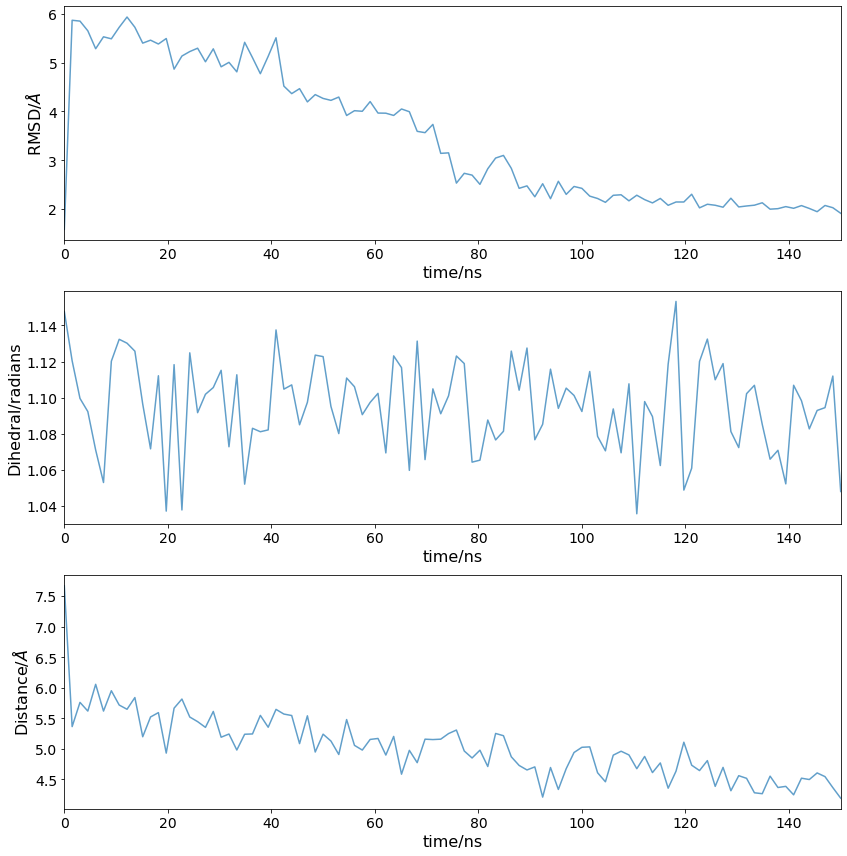

In [38]:
fig, ax = plt.subplots(3, figsize=(12, 12))

columns = ["r1", "t1", "d1"]
ylabels = ["RMSD/$\AA$", "Dihedral/radians", "Distance/$\AA$"]

for i in range(len(columns)):
    ax[i].plot(df.index[frames], df.iloc[frames][columns[i]], alpha=0.7)
    ax[i].set_ylabel(ylabels[i])
    ax[i].set_xlabel("time/ns")
    ax[i].set_xlim(0, 150)

fig.tight_layout()

Save each snapshot as a PDB:

In [ ]:
for i, index in enumerate(frames):
    frame = BSS.Trajectory.getFrame(
        trajectory="/home/adele/Documents/PTP1B/steering.nc",
        topology="/home/adele/Documents/PTP1B/system.prm7",
        index=int(index),
    )
    BSS.IO.saveMolecules(f"{snapshot_dir}/snapshot_{i+1}", frame, "pdb")

These PDB files are to be used as starting points for 100 individual 100 ns simulations, starting with resolvation, minimisation and equilibration. This is very time consuming and best done on an HPC cluster. An [example script](scripts/seededMD.py) that can be used with an array submission is provided. Note that due to the additional phospho residue parameters required it is specific to PTP1B with a peptide substrate, but the `load_system()` function can be easily modified to work with other systems, while the rest of the script is transferable.